<h1 align="center"><strong>malware prediction code</strong></h1>

<body>
    <div style = "
        width: 100%;
        height: 30px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(235, 238, 212));">
    </div>
</body>

In [ ]:
# Standard libraries
import gc
import warnings
import numpy as np
import pandas as pd
import dask.dataframe as dd
from tqdm.auto import tqdm
import time

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Third-party ML and encoding
from category_encoders import CountEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Machine learning models
from xgboost import XGBClassifier
import lightgbm as lgb

# Suppress warnings and configure logging
warnings.filterwarnings("ignore")

# Configuration
target_name = 'HasDetections'
file_path   = '../data/train.csv'

> ### **data_link →** [**Microsoft Malware Prediction**](https://www.kaggle.com/competitions/microsoft-malware-prediction/data)

<body>
    <div style = "
        width: 100%;
        height: 30px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(235, 238, 212));">
    </div>
</body>


# **1. Load Data**

In [ ]:
df = dd.read_csv(file_path, blocksize="32MB", assume_missing=True, low_memory=False, dtype={"Census_ProcessorClass": "object","PuaMode": "object"})
df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0.0,7.0,0.0,NaN,53447.0,...,36144.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,10.0,0.0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0.0,7.0,0.0,NaN,53447.0,...,57858.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,8.0,0.0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0.0,7.0,0.0,NaN,53447.0,...,52682.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0.0,7.0,0.0,NaN,53447.0,...,20050.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,3.0,1.0
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0.0,7.0,0.0,NaN,53447.0,...,19844.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
drop_cols = [
    "MachineIdentifier",      # Unique machine ID - no predictive value
    "CityIdentifier",         # Geographic ID - not useful for malware detection
    "OrganizationIdentifier"  # Company ID - could cause data leakage
]

print(f"Dropping ID columns: {drop_cols}")
df = df.drop(columns=drop_cols, errors="ignore")
df = df.drop_duplicates()

Dropping ID columns: ['MachineIdentifier', 'CityIdentifier', 'OrganizationIdentifier']


<body>
    <div style = "
        width: 100%;
        height: 30px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(235, 238, 212));">
    </div>
</body>

# **2. EDA , Preprocessing**

## **2.1. check for target's balance**

Target Distribution (HasDetections):
HasDetections
1    4458892
0    4462591
Name: count, dtype: int64
Balance Ratio: 1.00 (1.0 = perfectly balanced)


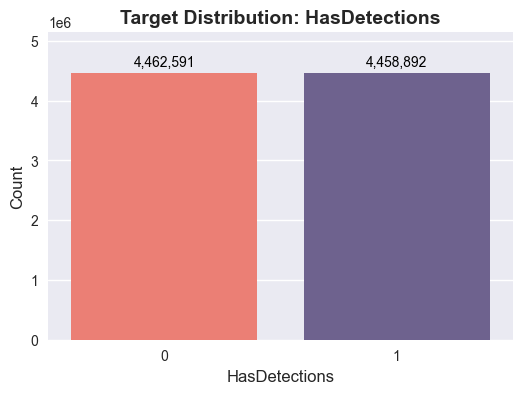

In [ ]:
def check_target_balance(df, target_name, plot=False, colors=['#FF6F61', '#6B5B95']):
    # Compute value counts for the target column
    counts = df[target_name].value_counts().compute()
    print(f"Target Distribution ({target_name}):\n{counts}")

    # Check if balanced
    balance_ratio = counts.max() / counts.min() if counts.min() > 0 else float('inf')
    print(f"Balance Ratio: {balance_ratio:.2f} (1.0 = perfectly balanced)")

    if plot:
        plt.style.use("seaborn-v0_8")
        plt.figure(figsize=(6, 4))
        ax = sns.barplot(x=counts.index, y=counts.values, palette=colors)

        # Annotate counts
        for p in ax.patches:
            ax.annotate(f"{int(p.get_height()):,}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10, color="black",  xytext=(0, 3), textcoords='offset points')

        ax.set_title(f"Target Distribution: {target_name}", fontsize=14, weight="bold")
        ax.set_xlabel(target_name, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)
        ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
        plt.show()

############################################################################
data = dd.read_csv(file_path, blocksize="32MB", usecols=[target_name])
check_target_balance(data, target_name, plot=True)

## **2.2. optimize data types**

In [ ]:
df_pandas = df.compute()
print(df_pandas.shape)
df_pandas.info()

(8913081, 80)
<class 'pandas.core.frame.DataFrame'>
Index: 8913081 entries, 254 to 65119
Data columns (total 80 columns):
 #   Column                                             Dtype  
---  ------                                             -----  
 0   ProductName                                        string 
 1   EngineVersion                                      string 
 2   AppVersion                                         string 
 3   AvSigVersion                                       string 
 4   IsBeta                                             float64
 5   RtpStateBitfield                                   float64
 6   IsSxsPassiveMode                                   float64
 7   DefaultBrowsersIdentifier                          float64
 8   AVProductStatesIdentifier                          float64
 9   AVProductsInstalled                                float64
 10  AVProductsEnabled                                  float64
 11  HasTpm                                   

In [ ]:
def optimize_dtypes(df):
    """Optimize DataFrame memory usage by downcasting numeric types and converting strings to categories."""
    initial_memory = df.memory_usage(deep=True).sum() / 1024**2

    # Downcast integers
    for col in df.select_dtypes(include=['int']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')

    # Downcast floats
    for col in df.select_dtypes(include=['float']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

    # Convert high-frequency strings to categorical
    for col in df.select_dtypes(include=['string', 'object']).columns:
        if df[col].nunique() < df.shape[0] * 0.5:  # Less than 50% unique
            df[col] = df[col].astype('category')

    final_memory = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Memory optimization: {initial_memory:.1f}MB → {final_memory:.1f}MB "f"({((initial_memory - final_memory) / initial_memory * 100):.1f}% reduction)")
    return df

############################################################################
df_opt = optimize_dtypes(df_pandas.copy())

Memory optimization: 7734.6MB → 2176.6MB (71.9% reduction)


In [ ]:
df_opt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8913081 entries, 254 to 65119
Data columns (total 80 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   ProductName                                        category
 1   EngineVersion                                      category
 2   AppVersion                                         category
 3   AvSigVersion                                       category
 4   IsBeta                                             float32 
 5   RtpStateBitfield                                   float32 
 6   IsSxsPassiveMode                                   float32 
 7   DefaultBrowsersIdentifier                          float32 
 8   AVProductStatesIdentifier                          float32 
 9   AVProductsInstalled                                float32 
 10  AVProductsEnabled                                  float32 
 11  HasTpm                                    

In [ ]:
print(f"Duplicates: {df_opt.duplicated().sum():,}")

Duplicates: 0


<body>
    <div style = "
        width: 100%;
        height: 10px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(67, 149, 173), rgb(235, 238, 212));">
    </div>
</body>

* #### **to show big variables in session and their sizes :**

In [ ]:
def show_variables(scope="global", min_size_mb=10):
    """Show variables in memory larger than a given size (MB) sorted from largest to smallest."""
    import sys
    variables = globals() if scope == "global" else locals()
    var_info  = []
    excluded_vars = {'_oh', '_dh', '_', 'exit', 'quit', 'get_ipython', 'In', 'Out'}

    for name, obj in variables.items():
        if (name.startswith("__") and name.endswith("__")) or name.startswith("_i") or (name.startswith("_") and name[1:].isdigit()) or name in excluded_vars:
            continue
        try:
            if isinstance(obj, pd.DataFrame):
                size = obj.memory_usage(deep=True).sum() / 1024 ** 2
            else:
                size = sys.getsizeof(obj) / 1024 ** 2
        except:
            size = 0
        if size >= min_size_mb:
            var_info.append((name, type(obj).__name__, size))

    var_info.sort(key=lambda x: x[2], reverse=True)
    df_vars = pd.DataFrame(var_info, columns=["Name", "Type", "Size_MB"])
    df_vars["Size (MB)"] = df_vars["Size_MB"].apply(lambda x: f"{x:.2f} MB")
    return df_vars.drop("Size_MB", axis=1).reset_index(drop=True)

############################################################################
def bulk_delete(vars_list, scope="global", save_deleted=False, return_type="dict"):
    """Delete multiple variables from memory (global or local scope)."""
    deleted_vars = {} if return_type == "dict" else []
    variables = globals() if scope == "global" else locals()
    for var_name in vars_list:
        if var_name in variables:
            if save_deleted:
                if return_type == "dict":
                    deleted_vars[var_name] = variables[var_name]
                else:
                    deleted_vars.append(variables[var_name])
            del variables[var_name]
    gc.collect()
    return deleted_vars if save_deleted else None

############################################################################
def show_var(MB= 1):
    display(show_variables(min_size_mb=MB))

############################################################################
def delete(vars_list):
    bulk_delete(vars_list)
    display(show_variables(min_size_mb=1))

############################################################################
show_var()

,Name,Type,Size (MB)
0,df_pandas,DataFrame,7734.63 MB
1,df_opt,DataFrame,2176.56 MB


In [ ]:
delete(['df_pandas'])

,Name,Type,Size (MB)
0,df_opt,DataFrame,2176.56 MB


## **2.3. Check for Missing values**

In [ ]:
def data_quality(df):
    from pandas.api.types import is_numeric_dtype, is_object_dtype, CategoricalDtype
    missing = df.isnull().sum()
    missing_per = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        "Missing_Count"      : missing,
        "Missing_Percentage" : missing_per,
        "Column_Type"        : ["Numeric" if is_numeric_dtype(df[c]) else "Categorical" if (is_object_dtype(df[c]) or isinstance(df[c].dtype, CategoricalDtype)) else "Other" for c in df.columns]
    }).query("Missing_Count > 0").sort_values("Missing_Percentage", ascending=False)

    if not missing_df.empty:
        def color_column_type(val):
            if val == "Numeric":
                return "background-color:#D6EAF8; color:#1B4F72; font-weight:bold;"
            elif val == "Categorical":
                return "background-color:#FADBD8; color:#641E16; font-weight:bold;"
            elif val == "Datetime":
                return "background-color:#E8F6F3; color:#0B5345; font-weight:bold;"
            else:
                return "background-color:#FDF2E9; color:#7D6608; font-weight:bold;"
        styled_df = (missing_df.style.applymap(color_column_type, subset=["Column_Type"]).background_gradient(subset=["Missing_Percentage"], cmap="Oranges").format({"Missing_Count": "{:.0f}", "Missing_Percentage": "{:.2f}%"}))
        display(styled_df)
        return missing_df

############################################################################
missing_df = data_quality(df_opt)

,Missing_Count,Missing_Percentage,Column_Type
PuaMode,8910776,99.97%,Categorical
Census_ProcessorClass,8876455,99.59%,Categorical
DefaultBrowsersIdentifier,8481098,95.15%,Numeric
Census_IsFlightingInternal,7400764,83.03%,Numeric
Census_InternalBatteryType,6330517,71.03%,Categorical
Census_ThresholdOptIn,5659668,63.50%,Numeric
Census_IsWIMBootEnabled,5652046,63.41%,Numeric
SmartScreen,3170874,35.58%,Categorical
SMode,535313,6.01%,Numeric
Wdft_RegionIdentifier,301827,3.39%,Numeric


<body>
    <div style = "
        width: 100%;
        height: 10px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(67, 149, 173), rgb(235, 238, 212));">
    </div>
</body>

* #### **to handle columns with >60% & <2% missing values:**

In [ ]:
high_cols_clean  = missing_df[missing_df['Missing_Percentage'] > 60].index.tolist()
print(f"Dropping columns with >60% missing: \n{high_cols_clean}\n")
df_opt.drop(columns=high_cols_clean, inplace=True)

Dropping columns with >60% missing: 
['PuaMode', 'Census_ProcessorClass', 'DefaultBrowsersIdentifier', 'Census_IsFlightingInternal', 'Census_InternalBatteryType', 'Census_ThresholdOptIn', 'Census_IsWIMBootEnabled']



In [ ]:
small_cols_clean = missing_df.loc[missing_df["Missing_Percentage"] <= 2, :].index.tolist()
df_opt = df_opt.dropna(subset=small_cols_clean)
missing_df = data_quality(df_opt)

,Missing_Count,Missing_Percentage,Column_Type
SmartScreen,2909465,35.05%,Categorical
SMode,499697,6.02%,Numeric
Wdft_IsGamer,252774,3.05%,Numeric
Wdft_RegionIdentifier,252774,3.05%,Numeric
Census_InternalBatteryNumberOfCharges,120805,1.46%,Numeric
Census_FirmwareManufacturerIdentifier,22566,0.27%,Numeric


## **2.4. separate numerical & categorical columns**

In [ ]:
df_opt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8300741 entries, 254 to 65119
Data columns (total 73 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   ProductName                                        category
 1   EngineVersion                                      category
 2   AppVersion                                         category
 3   AvSigVersion                                       category
 4   IsBeta                                             float32 
 5   RtpStateBitfield                                   float32 
 6   IsSxsPassiveMode                                   float32 
 7   AVProductStatesIdentifier                          float32 
 8   AVProductsInstalled                                float32 
 9   AVProductsEnabled                                  float32 
 10  HasTpm                                             float32 
 11  CountryIdentifier                         

In [ ]:
def get_column_types(df, numerics=['float32', 'float64'], show_summary=True):
    """Identify numerical and categorical columns in a DataFrame."""
    from itertools import zip_longest

    # Get numerical columns (numeric dtypes)
    numerical_columns = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and str(df[c].dtype) in numerics]

    # Get categorical columns (non-numeric dtypes or excluded numeric types)
    categorical_columns = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c]) or str(df[c].dtype) not in numerics]

    if show_summary:
        print(f"Column Type Summary:")
        print(f"   Numerical   : {len(numerical_columns)} columns")
        print(f"   Categorical : {len(categorical_columns)} columns")
        print(f"   Total       : {len(df.columns)} columns")

        print("\n Numerical Columns                                     | Categorical Columns")
        print("==========================================================================================")
        for i, (num, cat) in enumerate(zip_longest(numerical_columns, categorical_columns, fillvalue='')):
            print(f"{i+1:2d}. {num:<50} | {cat:<28}")
    return numerical_columns, categorical_columns

############################################################################
numerical_cols, categorical_cols = get_column_types(df_opt)

Column Type Summary:
   Numerical   : 47 columns
   Categorical : 26 columns
   Total       : 73 columns

 Numerical Columns                                     | Categorical Columns
 1. IsBeta                                             | ProductName                 
 2. RtpStateBitfield                                   | EngineVersion               
 3. IsSxsPassiveMode                                   | AppVersion                  
 4. AVProductStatesIdentifier                          | AvSigVersion                
 5. AVProductsInstalled                                | Platform                    
 6. AVProductsEnabled                                  | Processor                   
 7. HasTpm                                             | OsVer                       
 8. CountryIdentifier                                  | OsPlatformSubRelease        
 9. GeoNameIdentifier                                  | OsBuildLab                  
10. LocaleEnglishNameIdentifier            

<body>
    <div style = "
        width: 100%;
        height: 10px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(67, 149, 173), rgb(235, 238, 212));">
    </div>
</body>

> ## let's Start PreProcessing
```md
Is it Categorical?
├── YES → Missing values?
│           ├── YES → Impute with "Unknown"/Most frequent
│           └── NO
│
│      → Rare categories (< 5% frequency)?
│           ├── YES → Group into "Other"
│           └── NO
│
│      → Low cardinality (<15)?
│           ├── YES → One-Hot Encoding
│           └── NO  → Ordinal variable?
│                       ├── YES → Ordinal Encoding (define explicit order)
│                       └── NO  → High cardinality?
│                                   ├── YES → Target/Binary/Hash Encoding
│                                   └── NO  → Frequency/Count Encoding
│
└── NO → Numeric?
        ├── Discrete (few unique integers)
        │       ├── Small range (≤10 unique)?
        │       │       ├── YES → Treat as categorical
        │       │       └── NO  → Treat as continuous
        │       └── Missing values?
        │               ├── YES → Median/Mode
        │               └── NO
        │
        └── Continuous (real values)
                ├── Missing values?
                │       ├── YES → Mean/Median/Model-based
                │       └── NO
                │
                ├── Outliers present?
                │       ├── YES → Winsorize/Cap or use RobustScaler
                │       └── NO
                │
                ├── Scaling needed?
                │       ├── Tree-based models → No scaling needed
                │       └── Linear/NN/kNN models →
                │               ├── Normal distribution → StandardScaler
                │               ├── Heavy outliers      → RobustScaler  
                │               ├── Need [0,1] range    → MinMaxScaler
                │               └── Skewed              → Log/Box-Cox + StandardScaler
                │
                └── Special cases?
                        ├── Date/Time     → Extract features + cyclic encoding
                        ├── Text          → TF-IDF/Embeddings
                        └── Target skewed → Log transform target
```

## **2.5. Split Data**

In [ ]:
X = df_opt.drop(target_name, axis=1)
y = df_opt[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.3, random_state=42)

print(f"X → Train shape: {X_train.shape}\t, Test shape: {X_test.shape}")
print(f"y → Train shape: {y_train.shape}\t, Test shape: {y_test.shape}")

X → Train shape: (5810518, 72)	, Test shape: (2490223, 72)
y → Train shape: (5810518,)	, Test shape: (2490223,)


<body>
    <div style = "
        width: 100%;
        height: 10px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(67, 149, 173), rgb(235, 238, 212));">
    </div>
</body>

* #### **Categorical Columns Imputing:**

In [ ]:
missing_df = data_quality(X_train)

,Missing_Count,Missing_Percentage,Column_Type
SmartScreen,2036003,35.04%,Categorical
SMode,349637,6.02%,Numeric
Wdft_IsGamer,177078,3.05%,Numeric
Wdft_RegionIdentifier,177078,3.05%,Numeric
Census_InternalBatteryNumberOfCharges,84753,1.46%,Numeric
Census_FirmwareManufacturerIdentifier,15753,0.27%,Numeric


In [ ]:
X_train["SmartScreen"].unique().tolist()

[<NA>,
 'RequireAdmin',
 'Warn',
 'ExistsNotSet',
 'Off',
 'Prompt',
 '&#x02;',
 'Block',
 'On',
 'off',
 '&#x01;',
 'on',
 'Enabled',
 'requireadmin',
 '0',
 '&#x03;',
 'prompt',
 'OFF',
 'Promt',
 'requireAdmin',
 'warn',
 '00000000']

In [ ]:
def clean_smartscreen(X_train, X_test):
    """Clean and standardize SmartScreen values across train/test sets."""

    # Define cleaning pipeline
    null_mapping = {pd.NA: np.nan, "nan": np.nan}
    value_mapping = {
        'promt'       : 'prompt',
        'requireadmin': 'requireadmin',
        '&#x01;'      : 'unknown',
        '&#x02;'      : 'unknown',
        '&#x03;'      : 'unknown',
        '0'           : 'unknown',
        '00000000'    : 'unknown',
    }

    # Apply to both sets
    for df in [X_train, X_test]:
        df["SmartScreen"] = (df["SmartScreen"].replace(null_mapping).str.lower().replace(value_mapping))

    # Impute missing values
    imputer = SimpleImputer(strategy="constant", fill_value="unknown")
    X_train["SmartScreen"] = imputer.fit_transform(X_train[["SmartScreen"]])[:, 0]
    X_test["SmartScreen"] = imputer.transform(X_test[["SmartScreen"]])[:, 0]

    return X_train, X_test

X_train, X_test = clean_smartscreen(X_train, X_test)
display(X_train["SmartScreen"].unique().tolist())
missing_df = data_quality(X_train)

['unknown',
 'requireadmin',
 'warn',
 'existsnotset',
 'off',
 'prompt',
 'block',
 'on',
 'enabled']

,Missing_Count,Missing_Percentage,Column_Type
SMode,349637,6.02%,Numeric
Wdft_IsGamer,177078,3.05%,Numeric
Wdft_RegionIdentifier,177078,3.05%,Numeric
Census_InternalBatteryNumberOfCharges,84753,1.46%,Numeric
Census_FirmwareManufacturerIdentifier,15753,0.27%,Numeric


* ##### We will deal with this later

In [ ]:
show_var()

,Name,Type,Size (MB)
0,df_opt,DataFrame,1876.65 MB
1,X,DataFrame,1844.99 MB
2,X_train,DataFrame,1656.85 MB
3,X_test,DataFrame,710.37 MB
4,y,Series,94.99 MB
5,y_train,Series,66.50 MB
6,y_test,Series,28.50 MB


In [ ]:
delete(['X','y','df_opt'])

# Add after major operations:
print(f"Memory usage after preprocessing: {X_train.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

,Name,Type,Size (MB)
0,X_train,DataFrame,1656.85 MB
1,X_test,DataFrame,710.37 MB
2,y_train,Series,66.50 MB
3,y_test,Series,28.50 MB


Memory usage after preprocessing: 1656.8 MB


<body>
    <div style = "
        width: 100%;
        height: 10px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(67, 149, 173), rgb(235, 238, 212));">
    </div>
</body>

* #### **Encoding categorical features:**

In [ ]:
categorical_cols = [col for col in categorical_cols if col in X_train.columns]

cardinalities = {col: X_train[col].nunique() for col in categorical_cols}
sorted_cols   = sorted(categorical_cols, key=lambda c: cardinalities[c])

print("CATEGORICAL FEATURES ANALYSIS (sorted by cardinality):")
print("="*90)

for i, col in enumerate(sorted_cols, 1):
    n_uniques = cardinalities[col]
    uniques   = X_train[col].dropna().unique()

    # Determine encoding strategy
    if n_uniques < 10:
        strategy = "🟢 Ordinal/Label Encoding"
    elif n_uniques <= 500:
        strategy = "🟡 Frequency/Count Encoding"
    else:
        strategy = "🔴 Target/Hash + Rare Grouping"

    print(f"{i:2d}. {col:<35}: {n_uniques:>4d} unique | {strategy}")

    if n_uniques > 50:
        print(f"    ↪ Sample: {list(uniques)[:5]}...")
        print(f"    ↪ (Showing 5 of {n_uniques} categories)")
    else:
        print(f"    ↪ All values: {list(uniques)}")

    print("-" * 90)

# Summary
low_card  = len([c for c in categorical_cols if cardinalities[c] < 10])
med_card  = len([c for c in categorical_cols if 10 <= cardinalities[c] <= 500])
high_card = len([c for c in categorical_cols if cardinalities[c] > 500])

print(f"\n ENCODING STRATEGY SUMMARY:")
print(f"   🟢 Low cardinality (<10)       : {low_card} columns")
print(f"   🟡 Medium cardinality (10-500) : {med_card} columns")
print(f"   🔴 High cardinality (>500)     : {high_card} columns")

CATEGORICAL FEATURES ANALYSIS (sorted by cardinality):
 1. Platform                           :    3 unique | 🟢 Ordinal/Label Encoding
    ↪ All values: ['windows10', 'windows8', 'windows7']
------------------------------------------------------------------------------------------
 2. Processor                          :    3 unique | 🟢 Ordinal/Label Encoding
    ↪ All values: ['x86', 'x64', 'arm64']
------------------------------------------------------------------------------------------
 3. Census_DeviceFamily                :    3 unique | 🟢 Ordinal/Label Encoding
    ↪ All values: ['Windows.Desktop', 'Windows', 'Windows.Server']
------------------------------------------------------------------------------------------
 4. Census_OSArchitecture              :    3 unique | 🟢 Ordinal/Label Encoding
    ↪ All values: ['amd64', 'x86', 'arm64']
------------------------------------------------------------------------------------------
 5. ProductName                        :    4 unique

In [ ]:
def clean_categorical_features(X_train, X_test):
    """Systematically clean all categorical features."""
    # Define all cleaning rules
    cleaning_rules = {
        'Census_PrimaryDiskTypeName': {"UNKNOWN": "Unknown", "Unspecified": "Unknown"},
        'Census_OSWUAutoUpdateOptionsName': {"UNKNOWN": "Other"},
        'Census_GenuineStateName': {"UNKNOWN": "Invalid"},
        'SkuEdition': {"Invalid": "Other"},
        'SmartScreen': {"unknown": "Other"},
        'OsPlatformSubRelease': {"prers5": "rs5"},
        'Census_FlightRing': {"Unknown": "Other", "NOT_SET": "Other"},
        'Census_PowerPlatformRoleName': {"UNKNOWN": "Unknown", "Unspecified": "Unknown"},
        'Census_MDC2FormFactor': {"PCOther": "Other"},
        'Census_OSSkuName': {"UNLICENSED": "Invalid", "UNDEFINED": "Invalid"},
        'Census_OSEdition': {"professional": "Professional"},
        'Census_ChassisTypeName': {
            "UNKNOWN": "Unknown", "0": "Unknown", "30": "Unknown",
            "31": "Unknown", "35": "Unknown", "81": "Unknown",
            "32": "Unknown", "36": "Unknown", "127": "Unknown",
            "28": "Unknown", "39": "Unknown", "25": "Unknown"
        }
    }

    # Apply cleaning rules
    for column, rules in cleaning_rules.items():
        if column in X_train.columns:
            X_train[column] = X_train[column].replace(rules)
            X_test[column]  = X_test[column].replace(rules)
            print(f"✅ Cleaned {column}: {len(rules)} mappings applied")

    return X_train, X_test

X_train, X_test = clean_categorical_features(X_train, X_test)

✅ Cleaned Census_PrimaryDiskTypeName: 2 mappings applied
✅ Cleaned Census_OSWUAutoUpdateOptionsName: 1 mappings applied
✅ Cleaned Census_GenuineStateName: 1 mappings applied
✅ Cleaned SkuEdition: 1 mappings applied
✅ Cleaned SmartScreen: 1 mappings applied
✅ Cleaned OsPlatformSubRelease: 1 mappings applied
✅ Cleaned Census_FlightRing: 2 mappings applied
✅ Cleaned Census_PowerPlatformRoleName: 2 mappings applied
✅ Cleaned Census_MDC2FormFactor: 1 mappings applied
✅ Cleaned Census_OSSkuName: 2 mappings applied
✅ Cleaned Census_OSEdition: 1 mappings applied
✅ Cleaned Census_ChassisTypeName: 12 mappings applied


* ###  So let's spilt our encoding based on our features:
    * `<10`    : Label/Ordinal
    * `10–500` : Frequency Encoding
    * `>500`   : Feature Hashing or Frequency + Rare Grouping

In [ ]:
numerical_cols, categorical_cols = get_column_types(X_train, numerics=['float32', 'float64'])

Column Type Summary:
   Numerical   : 46 columns
   Categorical : 26 columns
   Total       : 72 columns

 Numerical Columns                                     | Categorical Columns
 1. IsBeta                                             | ProductName                 
 2. RtpStateBitfield                                   | EngineVersion               
 3. IsSxsPassiveMode                                   | AppVersion                  
 4. AVProductStatesIdentifier                          | AvSigVersion                
 5. AVProductsInstalled                                | Platform                    
 6. AVProductsEnabled                                  | Processor                   
 7. HasTpm                                             | OsVer                       
 8. CountryIdentifier                                  | OsPlatformSubRelease        
 9. GeoNameIdentifier                                  | OsBuildLab                  
10. LocaleEnglishNameIdentifier            

In [ ]:
# Get updated categorical columns and cardinalities
categorical_cols = [col for col in categorical_cols if col in X_train.columns]
cardinalities = {col: X_train[col].nunique() for col in categorical_cols}

# Define encoding strategy based on cardinality
low_card = [c for c in categorical_cols if cardinalities[c] < 10]
med_card = [c for c in categorical_cols if 10 <= cardinalities[c] <= 500]
high_card = [c for c in categorical_cols if cardinalities[c] > 500]

# Debug: Print the lists to verify they're not empty
print(f"Low    cardinality columns {len(low_card):<4} : {low_card}")
print(f"Medium cardinality columns {len(med_card):<4} : {med_card}")
print(f"High   cardinality columns {len(high_card):<4} : {high_card}\n")

# Get numerical columns
numerical_columns = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]

Low    cardinality columns 15   : ['ProductName', 'Platform', 'Processor', 'OsPlatformSubRelease', 'SkuEdition', 'SmartScreen', 'Census_DeviceFamily', 'Census_PrimaryDiskTypeName', 'Census_PowerPlatformRoleName', 'Census_OSArchitecture', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing']
Medium cardinality columns 9    : ['EngineVersion', 'AppVersion', 'OsVer', 'Census_MDC2FormFactor', 'Census_ChassisTypeName', 'Census_OSVersion', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName']
High   cardinality columns 2    : ['AvSigVersion', 'OsBuildLab']



In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CountWithRareGrouping(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.001):
        self.threshold = threshold
        self.count_encoders = {}
        self.rare_labels = {}
        self._output_config = None
    ##############################
    def set_output(self, *, transform=None):
        self._output_config = transform
        for col, encoder in self.count_encoders.items():
            if hasattr(encoder, 'set_output'):
                encoder.set_output(transform=transform)
        return self
    ##############################
    def fit(self, X, y=None):
        for col in X.columns:
            freq = X[col].value_counts(normalize=True)
            self.rare_labels[col] = freq[freq < self.threshold].index
            self.count_encoders[col] = CountEncoder(normalize=True)
            X_temp = X[[col]].copy()
            if pd.api.types.is_categorical_dtype(X_temp[col]):
                categories = X_temp[col].cat.categories
                if 'Other' not in categories:
                    X_temp[col] = X_temp[col].cat.add_categories(['Other'])
            X_temp.loc[X_temp[col].isin(self.rare_labels[col]), col] = 'Other'
            self.count_encoders[col].fit(X_temp)
        return self
    ##############################
    def transform(self, X):
        X_out = X.copy()
        for col in X.columns:
            if pd.api.types.is_categorical_dtype(X_out[col]):
                categories = X_out[col].cat.categories
                if 'Other' not in categories:
                    X_out[col] = X_out[col].cat.add_categories(['Other'])
            X_out.loc[X_out[col].isin(self.rare_labels[col]), col] = 'Other'
            X_out[col] = self.count_encoders[col].transform(X_out[[col]])[col]
        if self._output_config == 'pandas' and not isinstance(X_out, pd.DataFrame):
            X_out = pd.DataFrame(X_out, columns=X.columns)
        return X_out

############################################################################
# Create transformers list dynamically to avoid empty column lists
transformers = []
if low_card:
    transformers.append(('ordinalencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), low_card))
if med_card:
    transformers.append(('countencoder', CountEncoder(normalize=True), med_card))
if high_card:
    transformers.append(('countwithrare', CountWithRareGrouping(threshold=0.001), high_card))
if numerical_columns:
    transformers.append(('passthrough', 'passthrough', numerical_columns))

# Create ColumnTransformer
ct = ColumnTransformer(transformers=transformers, remainder='drop', verbose_feature_names_out=False)
ct.set_output(transform='pandas')

X_train = ct.fit_transform(X_train)

# Rename columns
new_columns = []
for col in X_train.columns:
    if col in low_card + med_card + high_card:
        new_columns.append(col + '_encoded')
    else:
        new_columns.append(col)
X_train.columns = new_columns

print("✅ Transformation completed successfully!")

X_test = ct.transform(X_test)
X_test.columns = new_columns

✅ Transformation completed successfully!


In [ ]:
show_var()

,Name,Type,Size (MB)
0,X_train,DataFrame,2283.03 MB
1,X_test,DataFrame,978.44 MB
2,y_train,Series,66.50 MB
3,y_test,Series,28.50 MB


In [ ]:
numerical_cols, categorical_cols = get_column_types(X_train, numerics = ['float32', 'float64'])

Column Type Summary:
   Numerical   : 72 columns
   Categorical : 0 columns
   Total       : 72 columns

 Numerical Columns                                     | Categorical Columns
 1. ProductName_encoded                                |                             
 2. Platform_encoded                                   |                             
 3. Processor_encoded                                  |                             
 4. OsPlatformSubRelease_encoded                       |                             
 5. SkuEdition_encoded                                 |                             
 6. SmartScreen_encoded                                |                             
 7. Census_DeviceFamily_encoded                        |                             
 8. Census_PrimaryDiskTypeName_encoded                 |                             
 9. Census_PowerPlatformRoleName_encoded               |                             
10. Census_OSArchitecture_encoded           

<body>
    <div style = "
        width: 100%;
        height: 10px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(67, 149, 173), rgb(235, 238, 212));">
    </div>
</body>

* #### **let's go to Numerical :**

In [ ]:
missing_df = data_quality(X_train)

,Missing_Count,Missing_Percentage,Column_Type
SMode,349637,6.02%,Numeric
Wdft_IsGamer,177078,3.05%,Numeric
Wdft_RegionIdentifier,177078,3.05%,Numeric
Census_InternalBatteryNumberOfCharges,84753,1.46%,Numeric
Census_FirmwareManufacturerIdentifier,15753,0.27%,Numeric


In [ ]:
missing_cols = missing_df.index.tolist() if missing_df is not None and not missing_df.empty else []
binary_cols  = [col for col in X_train.columns if set(X_train[col].dropna().unique()).issubset({0,1})]
binary_cols_NAN = [col for col in X_train.columns if col in missing_cols and set(X_train[col].dropna().unique()).issubset({0, 1})]

print(f'Binary columns with missing values: {len(binary_cols_NAN)}')
print(f'binary_cols_NAN: {binary_cols_NAN}')

Binary columns with missing values: 2
binary_cols_NAN: ['SMode', 'Wdft_IsGamer']


In [ ]:
if binary_cols_NAN:
    # Create summary
    binary_summary_for_NAN = pd.DataFrame({
        "Binary_Column": binary_cols_NAN,
        "Missing_Count": [X_train[col].isna().sum() for col in binary_cols_NAN],
        "Missing_Percentage": [X_train[col].isna().mean() * 100 for col in binary_cols_NAN]
    })
    binary_summary_for_NAN = binary_summary_for_NAN.sort_values(by="Missing_Count", ascending=False).reset_index(drop=True)
    display(binary_summary_for_NAN)

    # Store original column names for renaming
    original_columns = X_train.columns.tolist()

    # Create and apply ColumnTransformer
    ct = ColumnTransformer(
        transformers=[
            ('binary_imputer', SimpleImputer(strategy='most_frequent'), binary_cols_NAN),
            ('passthrough', 'passthrough', [col for col in X_train.columns if col not in binary_cols_NAN])
        ],
        remainder='drop',
        verbose_feature_names_out=False
    )

    ct.set_output(transform='pandas')

    # Transform data
    X_train = ct.fit_transform(X_train)
    X_test = ct.transform(X_test)

    # Fix column names (create mapping based on original columns)
    new_columns = [col + '_imputed' if col in binary_cols_NAN else col for col in original_columns]
    X_train.columns = new_columns
    X_test.columns = new_columns

    print("✅ Binary imputation completed successfully!")
    print(f"Transformed shape: {X_train.shape}")
    display(X_train.head())

    # Update binary_cols to reflect new column names
    binary_cols_updated = [col + '_imputed' if col in binary_cols_NAN else col for col in binary_cols]

else:
    print("ℹ️ No binary columns with missing values found. Skipping binary imputation.")
    # No changes to column names
    binary_cols_updated = binary_cols

# Verify no missing values in binary columns (use updated column names)
remaining_missing = X_train[binary_cols_updated].isnull().sum().sum()
print(f"Remaining missing values in binary columns: {remaining_missing}")

,Binary_Column,Missing_Count,Missing_Percentage
0,SMode,349637,6.017312
1,Wdft_IsGamer,177078,3.047542


✅ Binary imputation completed successfully!
Transformed shape: (5810518, 72)


,ProductName_encoded,Platform_encoded,Processor_encoded,OsPlatformSubRelease_encoded,SkuEdition_encoded,SmartScreen_encoded,Census_DeviceFamily_encoded,Census_PrimaryDiskTypeName_encoded,Census_PowerPlatformRoleName_encoded,Census_OSArchitecture_encoded,...,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer_imputed,Wdft_RegionIdentifier
8657,0.0,0.0,3.0,0.0,2.0,2.0,4.0,0.0,1.0,0.0,...,0.0,0.0,897.0,7414.0,0.0,0.0,0.0,0.0,0.0,NaN
669,0.0,0.0,3.0,0.0,1.0,0.0,4.0,7.0,1.0,0.0,...,0.0,0.0,556.0,7271.0,1.0,0.0,0.0,0.0,0.0,13.0
47719,0.0,0.0,3.0,0.0,1.0,2.0,4.0,7.0,1.0,0.0,...,0.0,0.0,554.0,33054.0,1.0,0.0,0.0,0.0,0.0,3.0
2664,0.0,0.0,3.0,0.0,2.0,3.0,4.0,7.0,1.0,1.0,...,0.0,0.0,628.0,31700.0,0.0,0.0,0.0,0.0,1.0,10.0
59686,0.0,0.0,3.0,0.0,1.0,2.0,4.0,7.0,1.0,0.0,...,0.0,0.0,142.0,9649.0,0.0,0.0,0.0,0.0,0.0,11.0


Remaining missing values in binary columns: 0


In [ ]:
show_var()

,Name,Type,Size (MB)
0,X_train,DataFrame,2283.03 MB
1,X_test,DataFrame,978.44 MB
2,y_train,Series,66.50 MB
3,y_test,Series,28.50 MB


In [ ]:
missing_df = data_quality(X_train)

,Missing_Count,Missing_Percentage,Column_Type
Wdft_RegionIdentifier,177078,3.05%,Numeric
Census_OSBuildNumber,84753,1.46%,Numeric
Census_FirmwareVersionIdentifier,15753,0.27%,Numeric


In [ ]:
def analyze_missing_columns(X_train, missing_df, display_threshold=70):
    """Analyze columns with missing values - show cardinality and unique values."""

    if missing_df is None or missing_df.empty:
        print("✅ No missing values found in the dataset!")
        return

    missing_cols = missing_df.index.tolist()
    print(f"MISSING VALUES ANALYSIS ({len(missing_cols)} columns)")
    print("=" * 100)

    for i, col in enumerate(missing_cols, 1):
        n_uniques = X_train[col].nunique()
        uniques = X_train[col].dropna().unique()
        missing_pct = X_train[col].isnull().mean() * 100
        dtype = str(X_train[col].dtype)

        # Determine imputation strategy suggestion
        if pd.api.types.is_numeric_dtype(X_train[col]):
            if n_uniques <= 10:
                strategy = "Mode (few unique values)"
            else:
                strategy = "Median (continuous)"
        else:
            strategy = "Mode/Unknown (categorical)"

        print(f"{i:2d}. {col:<40} | {n_uniques:>6d} unique | {missing_pct:>5.1f}% missing | {dtype:<10} | → {strategy}")

        if n_uniques > display_threshold:
            print(f"    ↪ Sample: {list(uniques)[:5]}... ({n_uniques:,} total)")
        else:
            print(f"    ↪ Values: {list(uniques)}")

        print("-" * 100)

############################################################################
analyze_missing_columns(X_train, missing_df)

MISSING VALUES ANALYSIS (3 columns)
 1. Wdft_RegionIdentifier                    |     15 unique |   3.0% missing | float32    | → Median (continuous)
    ↪ Values: [13.0, 3.0, 10.0, 11.0, 15.0, 5.0, 8.0, 2.0, 7.0, 1.0, 6.0, 4.0, 9.0, 12.0, 14.0]
----------------------------------------------------------------------------------------------------
 2. Census_OSBuildNumber                     |  33227 unique |   1.5% missing | float64    | → Median (continuous)
    ↪ Sample: [0.0, 364.0, 4294967295.0, 134.0, 61462.0]... (33,227 total)
----------------------------------------------------------------------------------------------------
 3. Census_FirmwareVersionIdentifier         |    617 unique |   0.3% missing | float32    | → Median (continuous)
    ↪ Sample: [897.0, 556.0, 554.0, 628.0, 142.0]... (617 total)
----------------------------------------------------------------------------------------------------


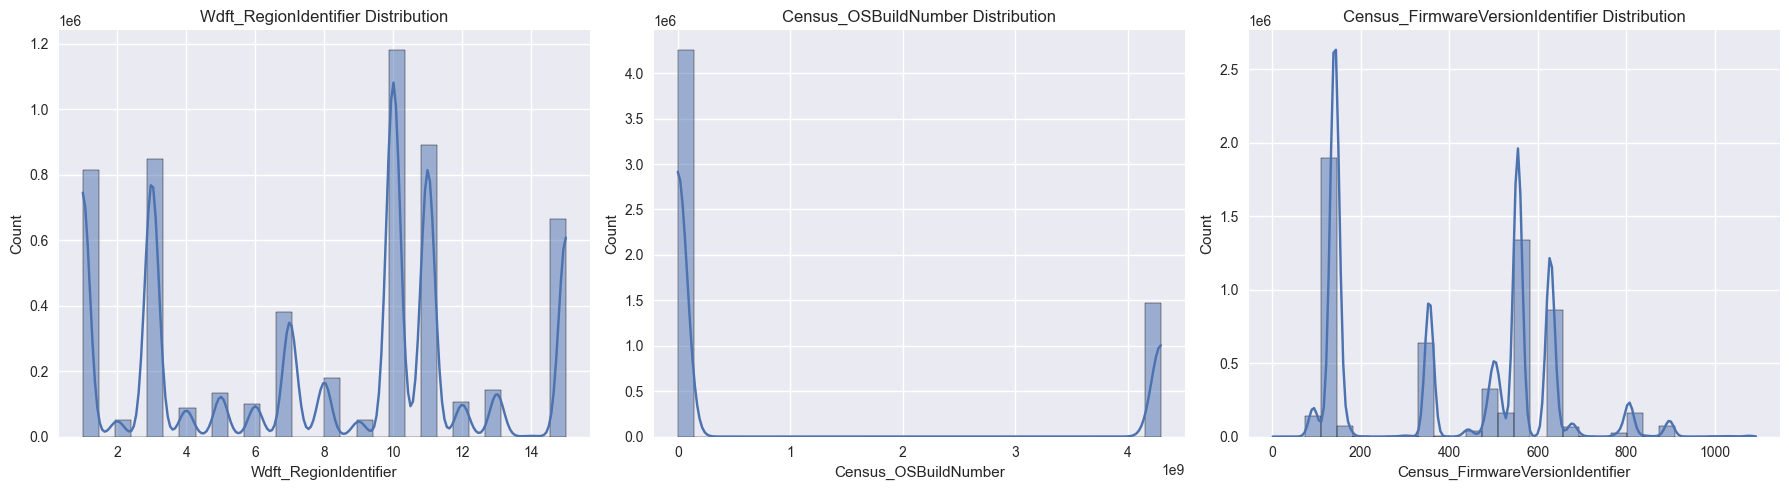

In [ ]:
missing_cols = missing_df.index.tolist() if missing_df is not None and not missing_df.empty else []

# Safe plotting - only if there are missing columns
if missing_cols:
    n_plots = len(missing_cols)
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

    # Handle case when there's only one plot
    if n_plots == 1:
        axes = [axes]

    for i, col in enumerate(missing_cols):
        sns.histplot(X_train[col], kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f'{col} Distribution', fontsize=12)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")

    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values to plot!")

In [ ]:
# Define imputation columns
mode_cols = ["Wdft_RegionIdentifier", "Census_FirmwareManufacturerIdentifier"]
median_cols = ["Census_InternalBatteryNumberOfCharges"]

# Store original columns for proper renaming
original_columns = X_train.columns.tolist()

# Create and apply ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ('mode_imputer', SimpleImputer(strategy='most_frequent'), mode_cols),
        ('median_imputer', SimpleImputer(strategy='median'), median_cols),
        ('passthrough', 'passthrough', [col for col in X_train.columns if col not in mode_cols + median_cols])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

ct.set_output(transform='pandas')

# Transform data
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

# Fix column names using original columns
new_columns = [col + '_imputed' if col in mode_cols + median_cols else col for col in original_columns]
X_train.columns = new_columns
X_test.columns = new_columns

print("✅ Imputation completed successfully!")
print(f"Transformed shape: {X_train.shape}")
display(X_train.head())

✅ Imputation completed successfully!
Transformed shape: (5810518, 72)


,ProductName_encoded,Platform_encoded,Processor_encoded,OsPlatformSubRelease_encoded,SkuEdition_encoded,SmartScreen_encoded,Census_DeviceFamily_encoded,Census_PrimaryDiskTypeName_encoded,Census_PowerPlatformRoleName_encoded,Census_OSArchitecture_encoded,...,Census_IsFlightsDisabled,Census_FirmwareManufacturerIdentifier_imputed,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer_imputed,Wdft_RegionIdentifier_imputed
8657,10.0,0.0,768.0,0.0,0.0,3.0,0.0,2.0,2.0,4.0,...,8.0,31.0,0.0,897.0,7414.0,0.0,0.0,0.0,0.0,0.0
669,13.0,0.0,900.0,0.0,0.0,3.0,0.0,1.0,0.0,4.0,...,8.0,31.0,0.0,556.0,7271.0,1.0,0.0,0.0,0.0,0.0
47719,3.0,0.0,768.0,0.0,0.0,3.0,0.0,1.0,2.0,4.0,...,32.0,136.0,0.0,554.0,33054.0,1.0,0.0,0.0,0.0,0.0
2664,10.0,0.0,768.0,0.0,0.0,3.0,0.0,2.0,3.0,4.0,...,8.0,31.0,0.0,628.0,31700.0,0.0,0.0,0.0,0.0,1.0
59686,11.0,0.0,768.0,0.0,0.0,3.0,0.0,1.0,2.0,4.0,...,35.0,148.0,0.0,142.0,9649.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
missing_df = data_quality(X_train)

,Missing_Count,Missing_Percentage,Column_Type
Census_OSInstallLanguageIdentifier,84753,1.46%,Numeric
Census_IsSecureBootEnabled,15753,0.27%,Numeric


In [ ]:
missing_df = data_quality(X_test)

,Missing_Count,Missing_Percentage,Column_Type
Census_OSInstallLanguageIdentifier,36052,1.45%,Numeric
Census_IsSecureBootEnabled,6813,0.27%,Numeric


In [ ]:
missing_cols = ['Census_OSInstallLanguageIdentifier', 'Census_IsSecureBootEnabled']

# Create masks for rows without missing values
train_complete = X_train[missing_cols].notna().all(axis=1)
test_complete = X_test[missing_cols].notna().all(axis=1)

# Apply masks
X_train, y_train = X_train[train_complete].reset_index(drop=True), y_train[train_complete].reset_index(drop=True)
X_test, y_test = X_test[test_complete].reset_index(drop=True), y_test[test_complete].reset_index(drop=True)

print(f"New shapes - Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Missing values remaining: {X_train.isnull().sum().sum()}")
print(f"Missing values remaining: {X_test.isnull().sum().sum()}")

New shapes - Train: (5710238, 72), Test: (2447453, 72)
Missing values remaining: 0
Missing values remaining: 0


In [ ]:
show_var(MB=0.01)

,Name,Type,Size (MB)
0,X_train,DataFrame,2200.07 MB
1,X_test,DataFrame,942.97 MB
2,train_complete,Series,49.87 MB
3,y_train,Series,21.78 MB
4,test_complete,Series,21.37 MB
5,y_test,Series,9.34 MB
6,uniques,Categorical,0.43 MB


In [ ]:
delete(['train_complete', 'test_complete', 'uniques'])

,Name,Type,Size (MB)
0,X_train,DataFrame,2200.07 MB
1,X_test,DataFrame,942.97 MB
2,y_train,Series,21.78 MB
3,y_test,Series,9.34 MB


In [ ]:
print("=" * 50)
print("FINAL DATA QUALITY CHECK")
print("=" * 50)
print(f"X_train shape: {X_train.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test  shape: {y_test.shape}")

print(f"\nMissing values:")
print(f"X_train : {X_train.isnull().sum().sum()}")
print(f"X_test  : {X_test.isnull().sum().sum()}")

print(f"\nMemory usage: {X_train.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print("✅ Ready for modeling!")

FINAL DATA QUALITY CHECK
X_train shape: (5710238, 72)
X_test  shape: (2447453, 72)
y_train shape: (5710238,)
y_test  shape: (2447453,)

Missing values:
X_train : 0
X_test  : 0

Memory usage: 2200.1 MB
✅ Ready for modeling!


<body>
    <div style = "
        width: 100%;
        height: 30px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(235, 238, 212));">
    </div>
</body>

# **3. Modeling**

In [ ]:
# Identify continuous features that might need scaling
continuous_cols = [
    "Census_TotalPhysicalRAM",
    "Census_PrimaryDiskTotalCapacity",
    "Census_SystemVolumeTotalCapacity",
    "Census_InternalPrimaryDiagonalDisplaySizeInInches",
    "Census_InternalPrimaryDisplayResolutionHorizontal",
    "Census_InternalPrimaryDisplayResolutionVertical",
    "Census_InternalBatteryNumberOfCharges_imputed",
    "Census_ProcessorCoreCount",
]

existing_continuous = [col for col in continuous_cols if col in X_train.columns]
other_features = [col for col in X_train.columns if col not in existing_continuous]

In [ ]:
if existing_continuous:
    # Scale continuous features, pass through others
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), existing_continuous),
            ('passthrough', 'passthrough', other_features)
        ],
        remainder='drop'
    )

    # Prepare data for modeling
    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)
else:
    # If no continuous features, use data as-is
    print("⚠️ No continuous features found - using data without scaling")
    X_train_scaled = X_train.values
    X_test_scaled = X_test.values

print(f"✅ Prepared data shape: Train={X_train_scaled.shape}, Test={X_test_scaled.shape}")

✅ Prepared data shape: Train=(5710238, 72), Test=(2447453, 72)


In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """Enhanced evaluation function with proper train/test evaluation."""

    print(f"{'='*60}")
    print(f"EVALUATION RESULTS: {model_name}")
    print(f"{'='*60}")

    # Train predictions
    y_train_pred   = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Test predictions
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"🎯 ACCURACY SCORES:")
    print(f"   Train Accuracy: {train_accuracy:.4f}")
    print(f"   Test  Accuracy:  {test_accuracy:.4f}")
    print(f"   Difference:     {abs(train_accuracy - test_accuracy):.4f}")

    if abs(train_accuracy - test_accuracy) > 0.05:
        print("   ⚠️ Possible overfitting detected!")
    else:
        print("   ✅ Good generalization!")

    # Detailed classification report (TEST SET)
    print(f"\n📋 CLASSIFICATION REPORT (Test Set):")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor='white', cbar=True, square=True,annot_kws={"size": 14, "weight": "bold"})
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix - {model_name} (Test Set)", fontsize=14)
    plt.tight_layout()
    plt.show()

    # ROC Curve and AUC (TEST SET)
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_test_proba)

        print(f"AUC Score (Test Set): {auc_score:.4f}")

        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curve - {model_name}', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return {'train_acc': train_accuracy, 'test_acc': test_accuracy, 'auc': auc_score}
    else:
        return {'train_acc': train_accuracy, 'test_acc': test_accuracy, 'auc': None}

<body>
    <div style = "
        width: 100%;
        height: 10px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(67, 149, 173), rgb(235, 238, 212));">
    </div>
</body>

* #### **1. XGBoost:**

🚀 Training XGBoost...


XGBoost Training:   0%|          | 0/100 [00:00<?]

EVALUATION RESULTS: XGBoost
🎯 ACCURACY SCORES:
   Train Accuracy: 0.6687
   Test  Accuracy:  0.6646
   Difference:     0.0041
   ✅ Good generalization!

📋 CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

         0.0       0.66      0.67      0.66   1219015
         1.0       0.67      0.66      0.66   1228438

    accuracy                           0.66   2447453
   macro avg       0.66      0.66      0.66   2447453
weighted avg       0.66      0.66      0.66   2447453



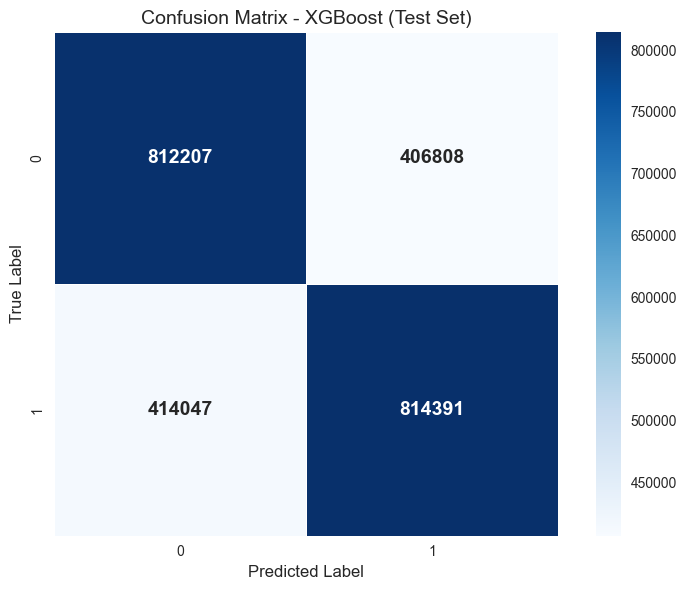

AUC Score (Test Set): 0.7304


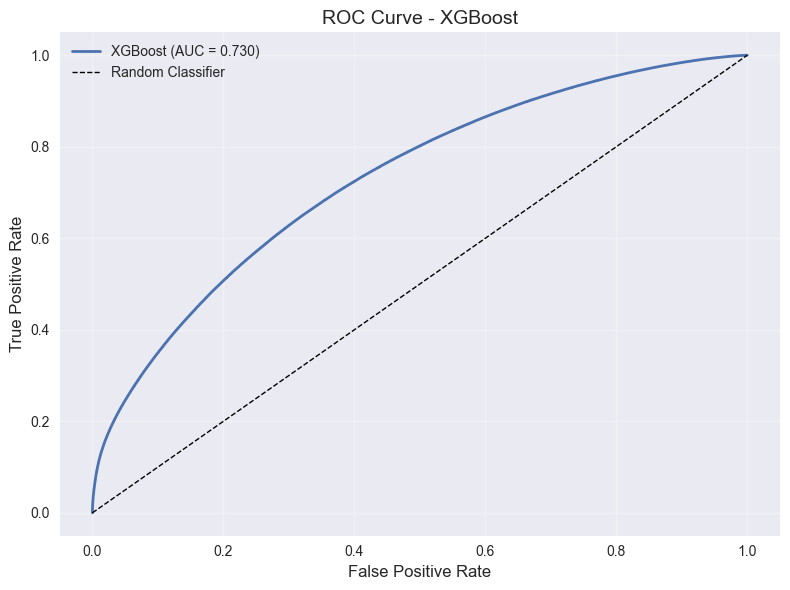

✅ XGBoost Training Complete! Time: 406.34s


In [ ]:
print("🚀 Training XGBoost...")

# Create a progress bar for XGBoost training
with tqdm(total=100, desc="XGBoost Training", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:

    xgb_model = XGBClassifier(
        # Core parameters
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,

        # Regularization (prevent overfitting)
        reg_alpha=0.1,
        reg_lambda=1.0,
        gamma=0.1,

        # Sampling (for speed and generalization)
        subsample=0.8,
        colsample_bytree=0.8,
        colsample_bylevel=0.8,

        # Performance
        tree_method='hist',
        grow_policy='depthwise',

        # Class imbalance handling
        scale_pos_weight=1,

        # System
        random_state=42,
        n_jobs=-1,
        eval_metric="auc",
        verbosity=0
    )

    pbar.update(20)  # Setup complete

    # Fit the model
    start_time = time.time()
    xgb_model.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time

    pbar.update(60)  # Training complete

    # Evaluate model
    xgb_results = evaluate_model(xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost")

    pbar.update(20)  # Evaluation complete

print(f"✅ XGBoost Training Complete! Time: {training_time:.2f}s")

* this code resource using vibe coding:

<body>
    <div style = "
        width: 100%;
        height: 10px;
        background: linear-gradient(to right,rgb(235, 238, 212),rgb(67, 149, 173), rgb(235, 238, 212));">
    </div>
</body>

* #### **2. LightGBM:**

🚀 Training LightGBM...


LightGBM Training:   0%|          | 0/100 [00:00<?]

EVALUATION RESULTS: LightGBM
🎯 ACCURACY SCORES:
   Train Accuracy: 0.6689
   Test  Accuracy:  0.6650
   Difference:     0.0039
   ✅ Good generalization!

📋 CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

         0.0       0.66      0.67      0.67   1219015
         1.0       0.67      0.66      0.66   1228438

    accuracy                           0.66   2447453
   macro avg       0.66      0.66      0.66   2447453
weighted avg       0.67      0.66      0.66   2447453



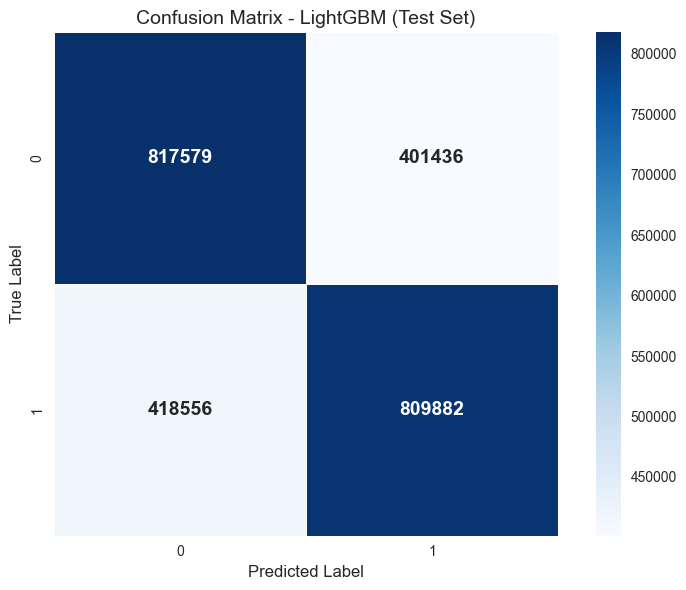

AUC Score (Test Set): 0.7307


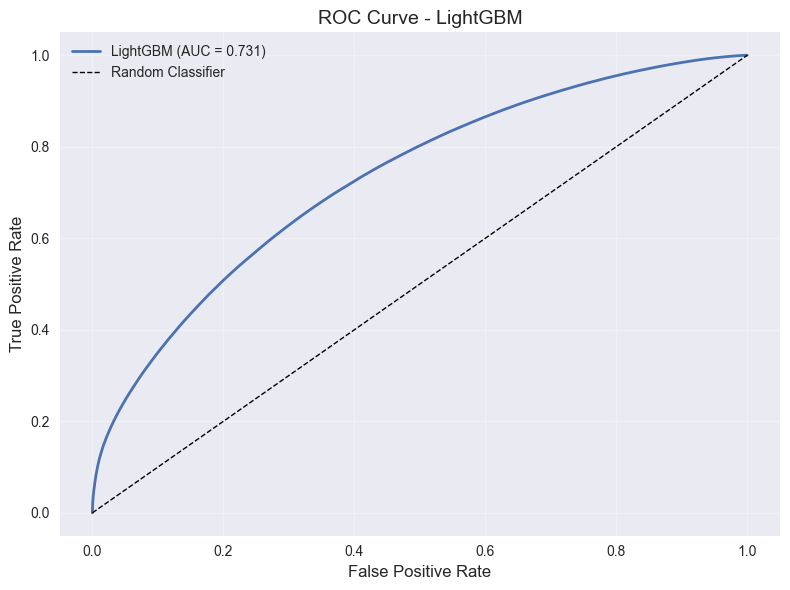

✅ LightGBM Training Complete! Time: 460.11s


In [ ]:
print("🚀 Training LightGBM...")

with tqdm(total=100, desc="LightGBM Training", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:

    lgb_model = lgb.LGBMClassifier(
        # Core parameters
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        num_leaves=255,

        # Regularization
        reg_alpha=0.1,
        reg_lambda=1.0,
        min_child_weight=5,
        min_child_samples=10,

        # Sampling
        subsample=0.8,
        colsample_bytree=0.8,
        subsample_freq=1,

        # Speed optimizations
        boosting_type='gbdt',
        objective='binary',
        metric='auc',

        # Class imbalance
        is_unbalance=True,

        # System
        random_state=42,
        n_jobs=-1,
        verbose=-1,
        force_col_wise=True
    )

    pbar.update(20)

    start_time = time.time()
    lgb_model.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time

    pbar.update(60)

    lgb_results = evaluate_model(lgb_model, X_train_scaled, X_test_scaled, y_train, y_test, "LightGBM")

    pbar.update(20)

print(f"✅ LightGBM Training Complete! Time: {training_time:.2f}s")